# 3. An LSTM language model

(consult *Recurrent Neural Network Regularization*, https://arxiv.org/pdf/1409.2329.pdf) 

In [0]:
!pip install -q torchtext 

import torch
import torchtext
from torchtext.vocab import Vectors
from torchtext.data.iterator import BPTTIterator
from torchtext.data import Batch, Dataset
import math


import numpy as np

from tqdm import tqdm_notebook
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# Our input $x$
TEXT = torchtext.data.Field()

!curl -qO https://raw.githubusercontent.com/harvard-ml-courses/cs287-s18/master/HW2/input.txt
!curl -qO https://raw.githubusercontent.com/harvard-ml-courses/cs287-s18/master/HW2/train.5k.txt
!curl -qO https://raw.githubusercontent.com/harvard-ml-courses/cs287-s18/master/HW2/train.txt
!curl -qO https://raw.githubusercontent.com/harvard-ml-courses/cs287-s18/master/HW2/valid.txt
!curl -qO https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.test.txt

# Data distributed with the assignment
train, val, test = torchtext.datasets.LanguageModelingDataset.splits(
    path=".", 
    train="train.txt", validation="valid.txt", test="ptb.test.txt", text_field=TEXT)

train_iter, val_iter, test_iter = BPTTIterator.splits(
    (train, val, test), batch_size=10, device=torch.device("cuda"), bptt_len=32, repeat=False)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  185k  100  185k    0     0  32332      0  0:00:05  0:00:05 --:--:-- 43547
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  595k  100  595k    0     0   965k      0 --:--:-- --:--:-- --:--:--  963k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4982k  100 4982k    0     0  5642k      0 --:--:-- --:--:-- --:--:-- 5635k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  390k  100  390k    0     0   684k      0 --:--:-- --:--:-- --:--:--  683k
  % Total    % Received % Xferd  Average Speed   Tim

In [0]:
TEXT.build_vocab(train) #for whole vocab
# TEXT.build_vocab(train, max_size=1000) #for sampling

In [0]:
class LSTM(nn.Module):
  def __init__(self, embed_size, V, batch_size, hidden_size, dropout, weight_bound):
    super(LSTM, self).__init__()
    self.batch_size = batch_size
    self.hidden_size = hidden_size

    self.embeddings = nn.Embedding(V, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, dropout=dropout)
    self.hidden = nn.Linear(in_features=hidden_size, out_features=V)
    self.dropout = nn.Dropout(p=dropout)

    # Init all parameters to a uniform distribution between the given weight bounds
    for params in self.lstm._all_weights:
      for param in params:
        if 'weight' in param:
          nn.init.uniform_(self.lstm.__getattr__(param), -weight_bound, weight_bound)
  
  def create_hidden_state(self):
    if torch.cuda.is_available():
      layer = Variable(torch.zeros(self.lstm.num_layers, self.batch_size, self.hidden_size)).cuda()
    else:
      layer = Variable(torch.zeros(self.lstm.num_layers, self.batch_size, self.hidden_size))
    return (layer, layer)
  
  def detach(self, hidden_state):
    return tuple([x.detach() for x in hidden_state])

  def forward(self, x, last_hidden, train=True):
    # Takes in hidden state, produces next hidden state
    embeds = self.embeddings(x)
    if train:
      embeds = self.dropout(embeds)
    out, next_hidden = self.lstm(embeds, last_hidden)
    out = out.view(-1, out.size(2))
    if train:
      out = self.dropout(out)
    out = self.hidden(out)
    logits = F.log_softmax(out, dim=1)
    return logits, self.detach(next_hidden)

class LSTMPretrained(nn.Module):
  def __init__(self, embed_size, V, batch_size, hidden_size, dropout, weight_bound, TEXT):
    super(LSTMPretrained, self).__init__()
    self.batch_size = batch_size
    self.hidden_size = hidden_size

    V, embed_size = TEXT.vocab.vectors.shape
    self.embeddings = nn.Embedding(V, embed_size)
    self.embeddings.weight.data.copy_(TEXT.vocab.vectors)

    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, dropout=dropout)
    self.hidden = nn.Linear(in_features=hidden_size, out_features=V)
    self.dropout = nn.Dropout(p=dropout)

    # Init all parameters to a uniform distribution between the given weight bounds
    for params in self.lstm._all_weights:
      for param in params:
        if 'weight' in param:
          nn.init.uniform_(self.lstm.__getattr__(param), -weight_bound, weight_bound)
  
  def create_hidden_state(self):
    if torch.cuda.is_available():
      layer = Variable(torch.zeros(self.lstm.num_layers, self.batch_size, self.hidden_size)).cuda()
    else:
      layer = Variable(torch.zeros(self.lstm.num_layers, self.batch_size, self.hidden_size))
    return (layer, layer)
  
  def detach(self, hidden_state):
    return tuple([x.detach() for x in hidden_state])

  def forward(self, x, last_hidden, train=True):
    # Takes in hidden state, produces next hidden state
    embeds = self.embeddings(x)
    if train:
      embeds = self.dropout(embeds)
    out, next_hidden = self.lstm(embeds, last_hidden)
    out = out.view(-1, out.size(2))
    if train:
      out = self.dropout(out)
    out = self.hidden(out)
    logits = F.log_softmax(out, dim=1)
    return logits, self.detach(next_hidden)

class LSTMTrainer:
  def __init__(self, train_iter, val_iter):
    self.train_iter = train_iter
    self.val_iter = val_iter
  
  def train(self, model, epochs, lr):
    loss_function = nn.NLLLoss(reduction="mean") #use negative log likelihood as the loss function, get ppl for free
    params = filter(lambda x: x.requires_grad, model.parameters())
    optimizer = optim.Adam(params=params, lr=lr)

    train_ppls = list()
    val_ppls = list()
    for epoch in tqdm_notebook(range(epochs)):
      hidden = model.create_hidden_state()
      epoch_losses = list()
      model.train()
      for batch in tqdm_notebook(self.train_iter):
        if torch.cuda.is_available():
          x, y = batch.text.cuda(), batch.target.view(-1).cuda()
        else:
          x, y = batch.text, batch.target.view(-1)
        optimizer.zero_grad()
        try:
          yhat, hidden = model.forward(x, hidden, train=True)
        except:
          print(x)
          print(hidden)
          raise
        loss = loss_function(yhat, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.lstm.parameters(), max_norm=5) #gradient clipping per Zaremba
        optimizer.step()
        epoch_losses.append(loss.item())

      # Get val acc at every epoch
      model.eval()
      train_ppl = np.exp(np.mean(epoch_losses))
      val_ppl = self.validate(model)
      print('Epoch={}\ttrain_ppl={}\tval_ppl={}\tloss={}'.format(epoch, train_ppl, val_ppl, np.mean(epoch_losses)))
      train_ppls.append(train_ppl)
      val_ppls.append(val_ppl)
    
    return train_ppls, val_ppls
  
  def validate(self, model):
    loss_function = nn.NLLLoss()
    hidden = model.create_hidden_state()
    losses = list()
    for batch in self.val_iter:
      x, y = batch.text, batch.target.view(-1)
      yhat, _ = model.forward(x, hidden, train=False)
      loss = loss_function(yhat, y)
      losses.append(loss.item())
    pp_val = np.exp(np.mean(losses))
    return pp_val

In [0]:
V = len(TEXT.vocab)
embed_size = 300
hidden_size = 650
dropout = 0.5
batch_size = 10
weight_bound = 0.05
print("vocab of len={}".format(V))
epochs=5
lr=1e-3

vocab of len=10001


In [0]:
lstm = LSTM(embed_size=embed_size, V=V, batch_size=batch_size, hidden_size=hidden_size, dropout=dropout, weight_bound=weight_bound)
lstm.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (embeddings): Embedding(10001, 300)
  (lstm): LSTM(300, 650, dropout=0.5)
  (hidden): Linear(in_features=650, out_features=10001, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [0]:
trainer = LSTMTrainer(train_iter, val_iter)
train_ppls, val_ppls = trainer.train(lstm, epochs, lr)

Epoch=0	train_ppl=345.88536459365804	val_ppl=226.3199944915747	loss=5.846107403957085


Epoch=1	train_ppl=210.2392209695731	val_ppl=180.64448870404664	loss=5.348246029855463


Epoch=2	train_ppl=172.93228623365908	val_ppl=164.22325530241199	loss=5.1529001088232675


Epoch=3	train_ppl=152.11533863911316	val_ppl=155.2367400396176	loss=5.024639039934194


Epoch=4	train_ppl=138.53061093262	val_ppl=149.96486931794567	loss=4.931091318770653



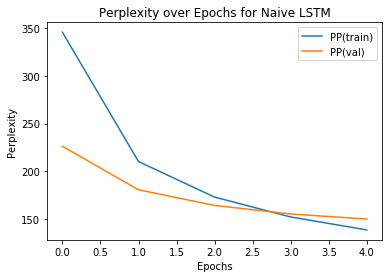

In [0]:
plt.plot(train_ppls, label="PP(train)")
plt.plot(val_ppls, label="PP(val)")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity over Epochs for Naive LSTM')
plt.show()

In [0]:
def get_test_pp(model, test_iter, trainer):
  with torch.no_grad():
    loss_function = nn.NLLLoss()
    losses = list()
    hidden = model.create_hidden_state()
    for batch in tqdm_notebook(test_iter, position=0, leave=True):
      x, y = batch.text, batch.target.view(-1)
      yhat, _ = model.forward(x, hidden, train=False)
      loss = loss_function(yhat, y)
      losses.append(loss.item())
    pp_test = np.exp(np.mean(losses))
    return pp_test

In [0]:
print('test pp: {}'.format(get_test_pp(lstm, test_iter, trainer)))


test pp: 139.4890462035677


In [0]:
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

.vector_cache/wiki.simple.vec: 293MB [00:25, 11.5MB/s]                           
 99%|█████████▉| 110446/111051 [00:10<00:00, 10111.82it/s]

In [0]:
# TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))
pretrained_lstm = LSTMPretrained(embed_size=embed_size, V=V, batch_size=batch_size, hidden_size=hidden_size, dropout=dropout, TEXT=TEXT, weight_bound=weight_bound)
pretrained_lstm.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTMPretrained(
  (embeddings): Embedding(10001, 300)
  (lstm): LSTM(300, 650, dropout=0.5)
  (hidden): Linear(in_features=650, out_features=10001, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [0]:
pretrained_trainer = LSTMTrainer(train_iter, val_iter)
pretrained_train_ppls, pretrained_val_ppls = pretrained_trainer.train(pretrained_lstm, epochs, lr)

Epoch=0	train_ppl=296.397909058071	val_ppl=189.69293746618987	loss=5.6917028389371


Epoch=1	train_ppl=154.80692421848542	val_ppl=152.63455827729896	loss=5.042178690248841


Epoch=2	train_ppl=117.95700121412652	val_ppl=133.89293787995774	loss=4.770320161566677


Epoch=3	train_ppl=99.03235657685339	val_ppl=123.7097694792831	loss=4.595446630845587


Epoch=4	train_ppl=87.10494765867772	val_ppl=120.41695384507638	loss=4.467113686592771



Exception ignored in: <bound method tqdm.__del__ of  99%|█████████▉| 110446/111051 [07:35<00:00, 10111.82it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


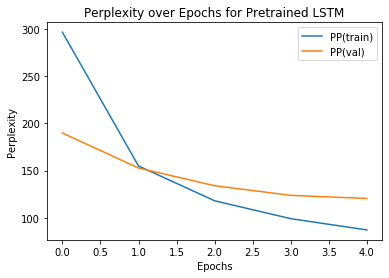

In [0]:
plt.plot(pretrained_train_ppls, label="PP(train)")
plt.plot(pretrained_val_ppls, label="PP(val)")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity over Epochs for Pretrained LSTM')
plt.show()

In [0]:
print('pretrained test pp: {}'.format(get_test_pp(pretrained_lstm, test_iter, pretrained_trainer)))

NameError: ignored

In [0]:
def get_H(x, y, model, trainer):
  with torch.no_grad():
    loss_function = nn.NLLLoss()
    hidden = model.create_hidden_state()
    yhat, _ = model.forward(x, hidden, train=False)
    H = loss_function(yhat, y)
    return H

In [0]:
examples = list()
for i, batch in enumerate(train_iter):
  if i in [1, 7]:
    examples.append((batch.text.data, batch.target.data))
for i, batch in enumerate(test_iter):
  if i in [117, 231]:
    examples.append((batch.text.data, batch.target.data))

In [0]:
entropies = list()
for context in examples:
  H = get_H(context[0], context[1].view(-1), pretrained_lstm, pretrained_trainer)
  entropies.append(H.item())
entropies

[4.363282203674316, 4.114250659942627, 4.6169843673706055, 4.53417444229126]